In [1]:
import numpy as np
from numpy.linalg import inv
from numpy.linalg import det

from sklearn.datasets import load_svmlight_file
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### [Volume Sampling for Linear Regression](https://arxiv.org/abs/1705.06908)
#### by [Michał Derezinski](https://users.soe.ucsc.edu/~mderezin/) and [Manfred K. Warmuth](https://users.soe.ucsc.edu/~manfred/)

This paper analyzes the problem of how to subsample data without significant degradation to the least squares estimator.  We are interested in the quantity $$ \hat{\mathbf{w}} = \mathbb{E}_{q(\mathbf{X}_{s}, \mathbf{y}_{s} | \mathbf{X}, \mathbf{y})}\left [\frac{\mathbf{X}_{s}^{T}\mathbf{y}_{s}}{\mathbf{X}_{s}^{T} \mathbf{X}_{s}} \right ] \approx \frac{\mathbf{\hat{X}}_{s}^{T}\mathbf{\hat{y}}_{s}}{\mathbf{\hat{X}}_{s}^{T} \mathbf{\hat{X}}_{s}} $$ where the expectation is taken over a subsampling mechanism $\mathbf{\hat{X}}_{s}, \mathbf{\hat{y}}_{s} \sim q(\mathbf{X}_{s}, \mathbf{y}_{s} | \mathbf{X}, \mathbf{y})$, $\mathbf{X}_{s}$ is an $s\in[d,N]$-sized subsample of the feature matrix, $\mathbf{y}_{s}$ are the responses associated with $\mathbf{X}_{s}$, and $\hat{\mathbf{w}}$ is the ordinary least squares estimate.  Specifically, the paper address the question: how should we set $q$ to ensure a good Monte Carlo estimate?  The answer is *volume sampling*.  For $M$ disjoint subsets $\{\mathbf{X}_{1,s},\ldots, \mathbf{X}_{m,s}, \ldots, \mathbf{X}_{M,s}\}$, all of size $s$, sample subsets according to: $$q(\mathbf{X}_{m,s}, \mathbf{y}_{m,s} | \mathbf{X}, \mathbf{y}) \propto | \mathbf{X}_{m,s}^{T} \mathbf{X}_{m,s} |$$ where $| \cdot |$ denotes the determinant.  The intuition behind the mechanism is that the determinant of the Gram feature matrix represents the [diversity](https://en.wikipedia.org/wiki/Determinantal_point_process) of the subset.  When the data is one-dimensional, sampling reduces to $ q(\mathbf{X}_{m,s}, \mathbf{y}_{m,s} | \mathbf{X}, \mathbf{y}) \propto \sum_{j=1}^{s} x_{m,j}^{2} $, and for single datapoints, we have $q(x_{i}|\mathbf{x},\mathbf{y}) \propto x_{i}^{2}$.  In the one-dimensional setting, we see that sampling large (absolute) values are desirable because they give the line its leverage.  Let's write some functions to calculate these quantities...    

In [2]:
def get_OLS_estimate(X, y):
    if len(X.shape) < 2:
        return np.dot(X,y)/np.dot(X,X)
    else:
        return np.dot(inv(np.dot(X.T, X) + .0000001*np.eye(X.shape[1])), np.dot(X.T, y))

def calc_subsample_probs(X, split_idxs):
    probs = []
    for idxs in split_idxs:
        X_s = X[idxs]
        if len(X.shape) < 2:
            probs.append(np.dot(X_s, X_s))
        else:
            probs.append(det(np.dot(X_s, X_s.T)))
        
    return np.array(probs)

### Experiment #1: One Dimensional Simulation

Let's simulate some one-dimensional data...

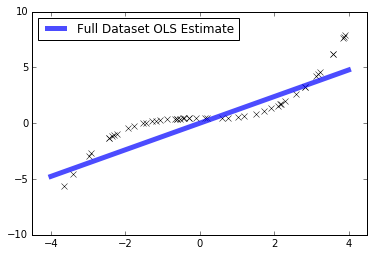

In [3]:
# Simulate data
N = 50
x = np.array([np.random.uniform(-4,4) for n in range(N)])
y = (x/2)**3 + np.random.normal() 

# Calculate OLS estimate
true_w_hat = get_OLS_estimate(x,y)

plt.plot(x, y, 'xk')
plt.plot([-4, 4], [-4*true_w_hat, 4*true_w_hat], 'b-', linewidth=5, alpha=.7, label="Full Dataset OLS Estimate")

plt.xlim([-4.5, 4.5])
plt.ylim([-10, 10])
plt.legend(loc=2)
plt.show()

Let's look at the distributions of lines estimated by using one data point for volume and uniform sampling...

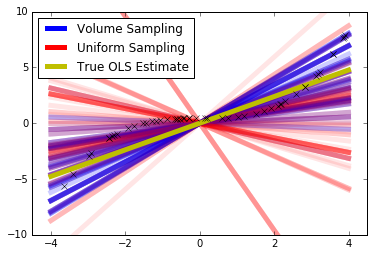

In [4]:
idx_probs = calc_subsample_probs(x, range(N))

for i in range(100):
    # volume
    sampled_idx = np.argmax(np.log(idx_probs) + np.random.gumbel(size=(N,)))
    w_hat = get_OLS_estimate(x[sampled_idx], y[sampled_idx])
    plt.plot([-4, 4], [-4*w_hat, 4*w_hat], 'b-', linewidth=5, alpha=.1)
    
    # uniform
    sampled_idx = np.argmax(np.log(1./N) + np.random.gumbel(size=(N,)))
    w_hat = get_OLS_estimate(x[sampled_idx], y[sampled_idx])
    plt.plot([-4, 4], [-4*w_hat, 4*w_hat], 'r-', linewidth=5, alpha=.1)
    
    
plt.plot([-4, 4], [100, 100], 'b-', linewidth=5, label="Volume Sampling")
plt.plot([-4, 4], [100, 100], 'r-', linewidth=5, label="Uniform Sampling")
plt.plot([-4, 4], [-4*true_w_hat, 4*true_w_hat], 'y-', linewidth=5, label="True OLS Estimate")

plt.plot(x, y, 'xk')
plt.xlim([-4.5, 4.5])
plt.ylim([-10, 10])
plt.legend(loc=2)
plt.show()

We see that there are several red lines (uniform sampling) that are clearly poor estimates, being nearly orthogonal to the true OLS solution.  Now let's look at RMSE as subsample size grows...

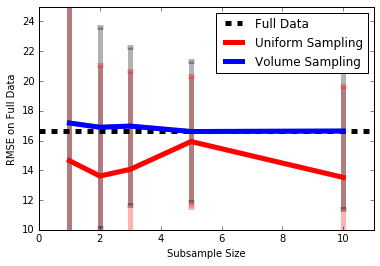

In [7]:
volume_rmse_means = []
volume_rmse_stds = []

uniform_rmse_means = []
uniform_rmse_stds = []

split_sizes = [1, 2, 3, 5, 10]

for s in split_sizes:
    # make splits
    idxs = range(N)
    np.random.shuffle(idxs)
    idx_splits = [idxs[k*s:(k+1)*s] for k in range(N/s)]
        
    # get split probs
    idx_probs = calc_subsample_probs(x, idx_splits)
    
    volume_rmse = []
    uniform_rmse = []
    # draw multiple samples
    for rerun in range(5000):
        #volume
        sampled_idx = np.argmax(np.log(idx_probs) + np.random.gumbel(size=(N/s,)))
        w_hat = get_OLS_estimate(x[idx_splits[sampled_idx]], y[idx_splits[sampled_idx]])
        volume_rmse.append(np.sqrt(np.mean((y-np.sum(x*w_hat))**2)))
        
        # uniform
        sampled_idx = np.argmax(np.log((s+0.)/N) + np.random.gumbel(size=(N/s,)))
        w_hat = get_OLS_estimate(x[idx_splits[sampled_idx]], y[idx_splits[sampled_idx]])
        uniform_rmse.append(np.sqrt(np.mean((y-np.sum(x*w_hat))**2)))
        
    volume_rmse_means.append(np.mean(volume_rmse))
    volume_rmse_stds.append(np.std(volume_rmse))
    uniform_rmse_means.append(np.mean(uniform_rmse))
    uniform_rmse_stds.append(np.std(uniform_rmse))
    
plt.plot([0,11], [np.sqrt(np.mean((y-np.sum(x*true_w_hat))**2))]*2, '--', color='black', markersize=10, mew=5, linewidth=5, label="Full Data")

plt.errorbar(split_sizes, uniform_rmse_means, yerr=uniform_rmse_stds, fmt='r-', markersize=10, mew=5, linewidth=5, alpha=.3)
plt.plot(split_sizes, uniform_rmse_means, '-', color='red', markersize=10, mew=5, linewidth=5, label="Uniform Sampling")

plt.errorbar(split_sizes, volume_rmse_means, yerr=volume_rmse_stds, fmt='k-', markersize=10, mew=5, linewidth=5, alpha=.3)
plt.plot(split_sizes, volume_rmse_means, '-', color='blue', markersize=10, mew=5, linewidth=5, label="Volume Sampling")

plt.xlabel("Subsample Size")
plt.ylabel("RMSE on Full Data")
plt.xlim([0, 11])
plt.ylim([10, 25])
plt.legend(loc=1)
plt.show()

We see that the volume sampling estimator is unbiased: as the RMSE estimate over multiple runs (blue line) matches the RMSE calculated on the full dataset (black line).  Interestingly, uniform sampling produces an estimator with downward bias, giving too optimistic of an error estimate.  

### Experiment #2: Cover-Type Dataset

Next, let's use a real dataset...

In [8]:
def _split_data(data, split):

    N = data.shape[0]
    if sum(split) != N:
        const = int(np.ceil(N / float(sum(split))))
    else:
        const = 1
    starts = np.cumsum(np.r_[0, split[:-1]] * const)
    ends = np.cumsum(split) * const
    if ends[-1] > N:
        ends[-1] = N
    splits = [data[s:e] for s, e in zip(starts, ends)]
    return splits

# /Desktop/UCIdatasets/libsvm/covtype.libsvm.binary.scale
def load_libsvm_data(dataset, splitPer = .2):
    if dataset[1]:
        X_train, y_train = load_svmlight_file("/Users/enalisnick/Desktop/UCIdatasets/libsvm/"+dataset[0])
        X_test, y_test = load_svmlight_file("/Users/enalisnick/Desktop/UCIdatasets/libsvm/"+dataset[1])
    else:
        X, y = load_svmlight_file("/Users/enalisnick/Desktop/UCIdatasets/libsvm/"+dataset[0])        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=splitPer, random_state=42)
    
    for y in [y_train, y_test]:
        for idx in xrange(len(y)):
            if y[idx] == -1: y[idx] = 0
            if y[idx] == 2: y[idx] = 0
            if y[idx] == 4: y[idx] = 1
        
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_libsvm_data(["covtype.libsvm.binary.scale", None])

In [9]:
# reduce train dataset to 10k
X_train = X_train[:10000, :].todense()
y_train = y_train[:10000][np.newaxis].T
X_test = X_test.todense()
y_test = y_test[np.newaxis].T

We'll run the same experiment as before (Subsample size vs RMSE) but measuring held-out data...

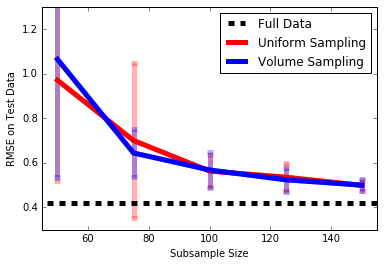

In [12]:
vol_rmse_means = []
vol_rmse_stds = []
uni_rmse_means = []
uni_rmse_stds = []

split_sizes = [50, 75, 100, 125, 150]
N = X_train.shape[0]
true_w_hat = get_OLS_estimate(X_train, y_train)

for s in split_sizes:
    # make splits
    idxs = range(N)
    np.random.shuffle(idxs)
    idx_splits = [idxs[k*s:(k+1)*s] for k in range(N/s)]
        
    # get split probs
    idx_probs = calc_subsample_probs(X_train, idx_splits)
    
    vol_rmse = []
    uni_rmse = []
    # draw multiple samples
    for rerun in range(100):
        # volume
        sampled_idx = np.argmax(np.log(idx_probs + .00001) + np.random.gumbel(size=(N/s,)))
        w_hat = get_OLS_estimate(X_train[idx_splits[sampled_idx]], y_train[idx_splits[sampled_idx]])
        vol_rmse.append(np.sqrt(np.mean(np.power(y_test-np.dot(X_test, w_hat),2))))
        
        # uniform
        sampled_idx = np.argmax(np.log((s+0.)/N) + np.random.gumbel(size=(N/s,)))
        w_hat = get_OLS_estimate(X_train[idx_splits[sampled_idx]], y_train[idx_splits[sampled_idx]])
        uni_rmse.append(np.sqrt(np.mean(np.power(y_test-np.dot(X_test, w_hat),2))))
        
    vol_rmse_means.append(np.mean(vol_rmse))
    vol_rmse_stds.append(np.std(vol_rmse))
    uni_rmse_means.append(np.mean(uni_rmse))
    uni_rmse_stds.append(np.std(uni_rmse))
    
plt.plot([0,501], [np.sqrt(np.mean(np.power(y_test-np.dot(X_test, true_w_hat),2)))]*2, '--', color='black', markersize=10, mew=5, linewidth=5, label="Full Data")

plt.errorbar(split_sizes, uni_rmse_means, yerr=uni_rmse_stds, fmt='r-', markersize=10, mew=5, linewidth=5, alpha=.3)
plt.plot(split_sizes, uni_rmse_means, '-', color='red', markersize=10, mew=5, linewidth=5, label="Uniform Sampling")

plt.errorbar(split_sizes, vol_rmse_means, yerr=vol_rmse_stds, fmt='b-', markersize=10, mew=5, linewidth=5, alpha=.3)
plt.plot(split_sizes, vol_rmse_means, '-', color='blue', markersize=10, mew=5, linewidth=5, label="Volume Sampling")

plt.xlabel("Subsample Size")
plt.ylabel("RMSE on Test Data")
plt.xlim([45, 155])
plt.ylim([0.3, 1.3])
plt.legend(loc=1)
plt.show()

We see that volume sampling gives some benefit for estimating held-out error, but the difference isn't dramatic. 